The goal of this topic is to determine the ideal projection when the dimensions of the input may vary (in columns). The dimensions of the columns are determined by feature generation/embeddings. 

Let:

*  $W$ be the projection matrix
*  $X$ to be the matrix representing input data which may vary in dimension from iteration to iteration
*  $Y$ be the result of the projection, i.e. $WX = Y$

WLOG fix the size of $Y$, (let's call this $d$). Then we have $W \in \mathbb{R}^{d \times n}$.

In this setting within the RJMCMC framework, the number of parameters we are estimating is:

*  all entries in $W$ ($d \times n$)  
*  all relevant combination of feature generation functions and their respective parameters 
                                             

### Examples of feature vector generation functions

As an example of an algorithm which we should compare is the multivariate adaptive regression splines (MARS)

**Hinge Function**

The hinge function ($f_\text{hinge}$) is similiar to ReLu), can be defined as a feature generation function, (_probably not the right way to write this out_)

$$ f_{\text{hinge}^+} (X_{j}, \theta) = (X_j-\theta \mathbf{1})_{+}$$

Where $X_j$ represents the $j$th column, without loss of generality we can likewise define $f_{\text{hinge}^-} (X_{j}, \theta) = (\theta \mathbf{1} - X_j)_{+}$

**Interaction**

Interaction term will be defined the dot product of two feature vectors (which can be the same feature vector), (_probably not the right way to write this out_)

$$ f_\text{interaction} (X_1, X_2) = X_1  \cdot X_2 $$

Replicating MARS in RJMCMC
--------------------------

[MARS](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines) is a prime candidate for exploring this problem. 

In the RJMCMC space we have the following decisions:

1. GROW - we can grow the state by Proposing a new feature vector generation transformation and respective parameter, e.g. hinge, interaction, or more complex function transforms which could be a composition of function generation...
2. DESTROY - we can also delete a created feature

This would be represent moving from one state to another.                                  

---

This notebook shows a sample pipeline that is to be learnt by feature discovery. 

In this example we will use 3 custom components:

*  Restricted Boltzmann Machine (which can be replaced with artibitary feature reduction method)
*  Hinge search (which can be replaced with any kind of feature discovery method, e.g. tfidf)
*  Interaction term (to create features like x^2 or x1*x2)

with these pieces we will be able to replicate (theoretically) models like MARS

In [1]:
import numpy as np
import pandas as pd

from hinge import Hinge, error_on_split
from interaction import Interaction
from rbm import *


from sklearn import datasets
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

In [2]:
iris = datasets.load_iris()

X = iris.data[:100, :]
y = iris.target[:100]

In [3]:
ds_pipeline = Pipeline([
    ('hinge', Hinge()), 
    ('interaction', Interaction([1,2])), 
    ('normalise_for_rbm', preprocessing.StandardScaler()),
    ('rbm', GaussianBernoulliRBM(3, n_iter=1000))
])

In [4]:
ds_pipeline.fit(X, y)

Pipeline(steps=[('hinge', Hinge(hinge=5.5, mask=0,
   psplit=<function error_on_split at 0x000001FFA2C14840>, search_min=True)), ('interaction', Interaction(interaction=[1, 2])), ('normalise_for_rbm', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rbm', GaussianBernoulliRBM(batch_size=10, learning_rate=0.1, n_components=3,
           n_iter=1000, random_state=None, sigma=1, verbose=False))])

In [5]:
resulting_ds = ds_pipeline.transform(X)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [10]:
from ggplot import *

rbm_df = pd.DataFrame(resulting_ds)
rbm_df.columns = ['feat{}'.format(x) for x in rbm_df.columns]
rbm_df['response'] = [str(x) for x in y]

In [11]:
rbm_df.head()

,feat0,feat1,feat2,response
0,0.999212,0.998844,0.033050,0
1,0.999100,0.999691,0.031631,0
2,0.999832,0.999744,0.030946,0
3,0.999804,0.999799,0.030551,0
4,0.999621,0.998904,0.032723,0


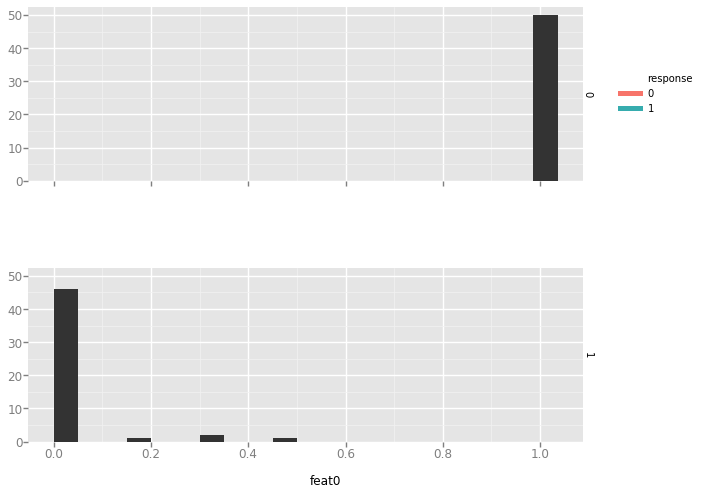

<ggplot: (137344770238)>

In [12]:
(ggplot(rbm_df, aes(x='feat0', fill='response')) + 
    geom_histogram(binwidth=0.05) + 
    facet_grid('response'))

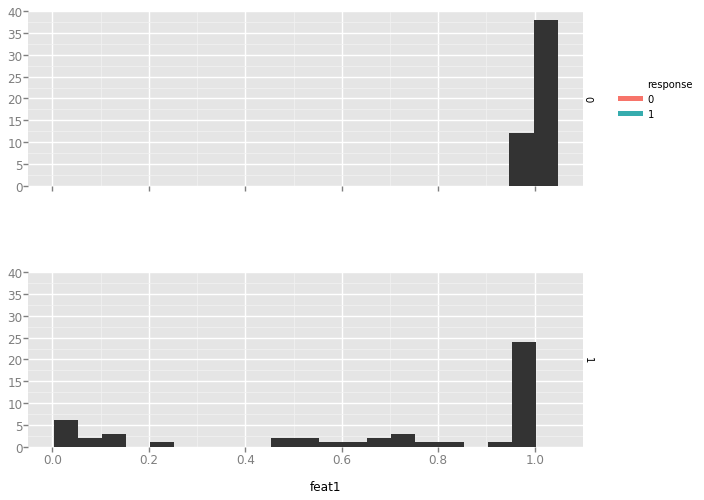

<ggplot: (137344994838)>

In [13]:
(ggplot(rbm_df, aes(x='feat1', fill='response')) + 
    geom_histogram(binwidth=0.05) + 
    facet_grid('response'))